# Final Project Submission

* Student name: Jonathan Vasquez
* Student pace: Full Time
* Scheduled project review date/time: 
* Instructor name: Fangfang Lee, SeanAbu Wilson, Matthew Wasserman
* Blog post URL:

# Importing Libraries

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import os, shutil
import tensorflow as tf
import seaborn as sns
import pandas as pd
import cv2
import glob
import random
import keras
import PIL.Image
import matplotlib.image as mpimg
import re

from keras import models, layers
from keras.models import Model, load_model, Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Dense, Dropout, Flatten, ZeroPadding2D
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical 
from keras.optimizers import Adam, SGD, RMSprop 
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications import vgg16
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16

from IPython.display import display
from random import randint
from pathlib import Path
from PIL import Image
from glob import glob 
import splitfolders 

from bokeh.models import ColumnDataSource, HoverTool, Panel, FactorRange
from bokeh.plotting import figure
from bokeh.io import output_notebook, show, output_file
from bokeh.palettes import Spectral6

from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, f1_score

np.random.seed(123)

# Importing Data

In [2]:
#Setting the Base Directory
root_dir = "mol_images/"
root_dir

'mol_images/'

In [4]:
##Converting PNG to JPG. NO NEED TO RUN AGAIN
#images_shape = []
#for k, image_path in enumerate(glob(root_dir + "*/*")):
#    im = Image.open(image_path)
#    rgb_im = im.convert('RGB')
#    rgb_im.save(image_path.replace("png", "jpg"), quality=95)

In [5]:
##Split with a ratio. NO NEED TO RUN AGAIN
#splitfolders.ratio(root_dir, output="output", seed=1337, 
#                   ratio=(.8, .1, .1), group_prefix=None) # default values

In [3]:
train_dir = os.path.join(root_dir, "train/")
test_dir = os.path.join(root_dir, "test/")
val_dir = os.path.join(root_dir, "val/")

In [4]:
# glob data together to get TOXIC and NOT_TOXIC images
toxic = glob(train_dir + "toxic/*")
not_toxic = glob(test_dir + "not_toxic/*")

Display NOT_TOXIC Images


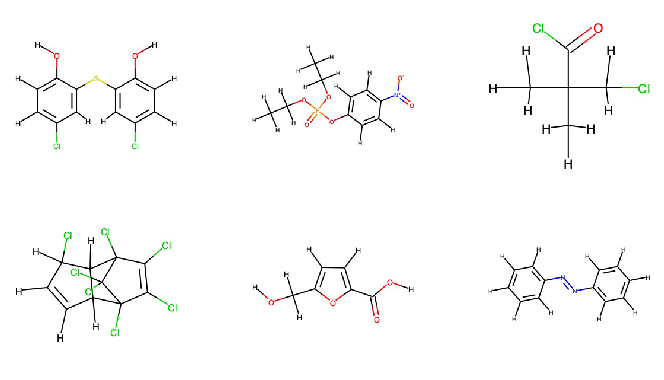

In [5]:
# extract 6 random images from NOT_TOXIC
random_images = [not_toxic[i] for i in range(6)]

print('Display NOT_TOXIC Images')

# adjust the size of the images
plt.figure(figsize=(10,8))

# iterate and plot random images
for i in range(6):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(random_images[i])
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# adjust subplot parameters to give specified padding
plt.tight_layout()

Display TOXIC Images


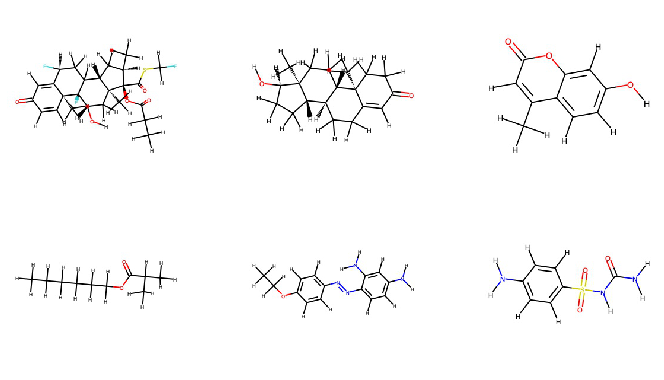

In [6]:
# extract 6 random images from TOXIC
random_images = [toxic[i] for i in range(10)]

print('Display TOXIC Images')

# adjust the size of the images
plt.figure(figsize=(10,8))

# iterate and plot random images
for i in range(6):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(random_images[i])
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# adjust subplot parameters to give specified padding
plt.tight_layout()

# EDA/Data Cleaning

In [7]:
# let's find out how many images we have in each folder
print("Number of images in Train is {}".format(len(glob(train_dir + "*/*"))))
print("Number of images in Test is {}".format(len(glob(test_dir + "*/*"))))
print("Number of images in Validation is {}".format(len(glob(val_dir + "*/*"))))

Number of images in Train is 11199
Number of images in Test is 1387
Number of images in Validation is 1395


In [8]:
# time to check the distribution of images within each category
Categories = ["Train", "Test", "Validation"]
Subcategories = ['TOXIC', 'NOT_TOXIC']

Train = [5635, 690]
Test = [5564, 697]
Validation = [700, 695]

data = {'Categories':Categories,
        'Train':Train,
        'Test':Test,
        'Validation':Validation}

x = [(categories, subcategories) 
     for categories in Categories for subcategories in Subcategories]
counts = sum(zip(data['Train'], data['Test'], data['Validation']), ())

source = ColumnDataSource(data=dict(x=x, counts=counts, color=Spectral6))

p = figure(x_range=FactorRange(*x), 
           plot_height=600, 
           plot_width=1000, title="Distribution of images with different category",
           tools="hover, pan, box_zoom, wheel_zoom, reset, save", tooltips= ("@x: @counts"))

p.vbar(x='x', top='counts', width=0.9, color='color', legend_field="x", source=source)

p.xgrid.grid_line_color = None
p.legend.orientation = "horizontal"
p.legend.location = "top_center"
output_notebook()
show(p)

Loading BokehJS ...

# Data Processing/Data Augmentation

In [10]:
# image preprocessing
train_datagen = ImageDataGenerator(rotation_range = 30,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   horizontal_flip = True,  
                                   # horizontal flip added to ensure proper learning
                                   rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [11]:
# creation of training, validation, and test sets, including augmentation for the training set
batch_size = 16
training_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size = (300, 300), 
                                                 batch_size = batch_size, 
                                                 class_mode = "binary") 
                                            #binary class because either toxic or not toxic
val_set = val_datagen.flow_from_directory(val_dir,
                                          target_size = (300, 300),
                                          batch_size = batch_size,
                                          class_mode = 'binary')
test_set = test_datagen.flow_from_directory(test_dir,
                                            target_size = (300, 300),
                                            batch_size = batch_size,
                                            class_mode = 'binary')

Found 11199 images belonging to 2 classes.
Found 1395 images belonging to 2 classes.
Found 1387 images belonging to 2 classes.


# Base CNN

In [12]:
# vanilla CNN consisting of 2 Zero Padding layers, 2 Convolutional layers, 2 Pooling layers, 
# Flatten, 2 Dense, 2 Dropout, & Output layer
cnn = models.Sequential()
cnn.add(ZeroPadding2D((1,1),input_shape=(300,300,3)))
cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(ZeroPadding2D((1,1)))
cnn.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(32, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(layers.Dense(32, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(layers.Dense(1, activation='sigmoid'))

# set variable for learning rate so that it can be tuned
optimizer = Adam(lr = 0.001)

cnn.compile(loss='binary_crossentropy', optimizer=optimizer, 
            metrics=['accuracy',tf.keras.metrics.Precision(name='precision'),
                     tf.keras.metrics.Recall(name='recall')])

In [13]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 302, 302, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 300, 300, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 64)      0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 152, 152, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 180000)            0

# Initial CNN

In [14]:
cnn1 = cnn.fit(training_set, 
               epochs=10, 
               workers=-1, 
               validation_data=val_set, 
               shuffle=True)

Epoch 1/10
700/700 [==============================] - 1167s 2s/step - loss: 0.6432 - accuracy: 0.6535 - precision: 0.6961 - recall: 0.5528 - val_loss: 0.6797 - val_accuracy: 0.6301 - val_precision: 0.7447 - val_recall: 0.4000
Epoch 2/10
700/700 [==============================] - 1004s 1s/step - loss: 0.5668 - accuracy: 0.7339 - precision: 0.8670 - recall: 0.5565 - val_loss: 0.6789 - val_accuracy: 0.5943 - val_precision: 0.6573 - val_recall: 0.4000
Epoch 3/10
700/700 [==============================] - 869s 1s/step - loss: 0.5643 - accuracy: 0.7346 - precision: 0.8552 - recall: 0.5689 - val_loss: 0.6415 - val_accuracy: 0.6115 - val_precision: 0.7724 - val_recall: 0.3200
Epoch 4/10
700/700 [==============================] - 852s 1s/step - loss: 0.5492 - accuracy: 0.7401 - precision: 0.8588 - recall: 0.5785 - val_loss: 0.6488 - val_accuracy: 0.6251 - val_precision: 0.7311 - val_recall: 0.4000
Epoch 5/10
700/700 [==============================] - 861s 1s/step - loss: 0.5391 - accuracy: 0.74

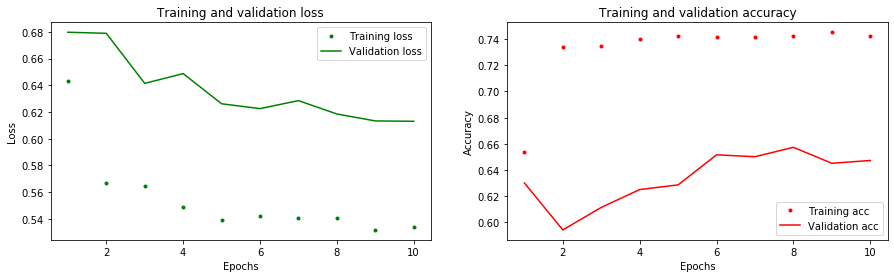

In [15]:
# visualization of loss and accuracy over the 50 epochs
hist_cnn = cnn1.history
loss_values = hist_cnn['loss']
val_loss_values = hist_cnn['val_loss']
acc_values = hist_cnn['accuracy'] 
val_acc_values = hist_cnn['val_accuracy']


epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(epochs, loss_values, 'g.', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc_values, 'r.', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Base Model Results

In [16]:
test_accu = cnn.evaluate(test_set)

87/87 [==============================] - 22s 251ms/step - loss: 0.5473 - accuracy: 0.7282 - precision: 0.8337 - recall: 0.5667


In [17]:
print('The testing accuracy is :',test_accu[1]*100, '%')

The testing accuracy is : 72.81903624534607 %


Here are the actual classes for each image
['mol_images/test/toxic/TOX3679 copy.jpg', 'mol_images/test/toxic/TOX4662 copy 20.jpg', 'mol_images/test/toxic/TOX27006 copy 21.jpg', 'mol_images/test/not_toxic/TOX21356.jpg', 'mol_images/test/not_toxic/TOX5474.jpg', 'mol_images/test/toxic/TOX26892 copy 18.jpg', 'mol_images/test/not_toxic/TOX28947.jpg', 'mol_images/test/not_toxic/TOX25989.jpg', 'mol_images/test/not_toxic/TOX6619.jpg']
Below are the predictions


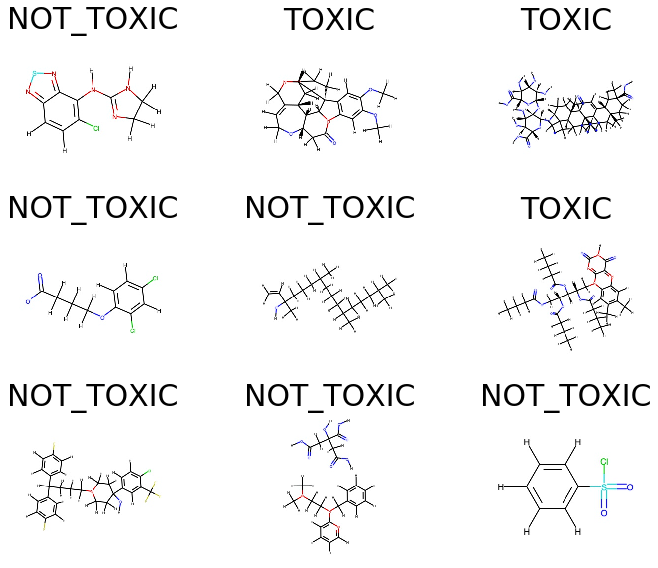

In [18]:
# extract 9 random images from the test set
imageset = glob(test_dir + "*/*")
random_images = [np.random.choice(imageset) for i in range(9)]

print('Here are the actual classes for each image')
print(random_images)
print('Below are the predictions')

# adjust the size of the images
plt.figure(figsize=(10,8))

# iterate and plot random images
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = cv2.imread(random_images[i])
    orig = img.copy()
    img = cv2.resize(img, (300,300))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img/255
    prediction = cnn.predict(img)
    
    if (prediction < 0.5):
        plt.title("NOT_TOXIC", fontdict = {'fontsize' : 30})
    
    else:
        plt.title("TOXIC", fontdict = {'fontsize' : 30})
    plt.imshow(orig, cmap='gray')
    plt.axis('off')
    
# adjust subplot parameters to give specified padding
plt.tight_layout()

# Transfer Learning - VGG16

In [19]:
# setting image size
img_rows, img_cols = 300, 300

vgg16_model = vgg16.VGG16(weights= 'imagenet', 
                    include_top=False, 
                    input_shape=(img_rows, img_cols, 3))

In [20]:
# freezing the layers 
for layer in vgg16_model.layers:
    layer.trainable = False

In [21]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0     

In [22]:
# adding additional layers for hyperparameter tuning
def layer_adder(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dense(512, activation='relu')(top_model)
    top_model = Dense(1, activation='sigmoid')(top_model)
    return top_model

In [23]:
# pulling together the entire model
num_classes = 2

FC_Head = layer_adder(vgg16_model, num_classes)

vgg16_model = Model(inputs = vgg16_model.input, outputs = FC_Head)

print(vgg16_model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0     

# Fitting the Model

5+6+

In [30]:
checkpoint = ModelCheckpoint('face_detector.h15', 
                             monitor = 'val_loss', 
                             mode = 'min', 
                             save_best_only = True, 
                             verbose = 1)
earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta = 0, 
                          patience = 3, 
                          verbose = 1, 
                          restore_best_weights= True)
callbacks = [earlystop, checkpoint]

vgg16_model.compile(loss = 'binary_crossentropy', 
              optimizer = 'Adam', 
              metrics=['accuracy',tf.keras.metrics.Precision(name='precision'),
                     tf.keras.metrics.Recall(name='recall')])

nb_train_samples = 11199
nb_validation_samples = 1395

epochs = 25
batch_size = 16

history = vgg16_model.fit_generator(training_set,
                                    epochs=epochs,
                                    callbacks = callbacks,
                                    validation_data= val_set)

Epoch 1/25
700/700 [==============================] - ETA: 0s - loss: 0.4337 - accuracy: 0.7736 - precision: 0.8580 - recall: 0.6593
Epoch 00001: val_loss improved from inf to 0.89061, saving model to face_detector.h15
INFO:tensorflow:Assets written to: face_detector.h15/assets
700/700 [==============================] - 3387s 5s/step - loss: 0.4337 - accuracy: 0.7736 - precision: 0.8580 - recall: 0.6593 - val_loss: 0.8906 - val_accuracy: 0.6115 - val_precision: 0.8376 - val_recall: 0.2800
Epoch 2/25
700/700 [==============================] - ETA: 0s - loss: 0.4217 - accuracy: 0.7756 - precision: 0.8361 - recall: 0.6891
Epoch 00002: val_loss did not improve from 0.89061
700/700 [==============================] - 3303s 5s/step - loss: 0.4217 - accuracy: 0.7756 - precision: 0.8361 - recall: 0.6891 - val_loss: 1.0719 - val_accuracy: 0.6409 - val_precision: 0.7386 - val_recall: 0.4400
Epoch 3/25
700/700 [==============================] - ETA: 0s - loss: 0.4082 - accuracy: 0.7827 - precision

# Transfer Learning Model Results

In [31]:
test_accu = vgg16_model.evaluate(test_set)

87/87 [==============================] - 278s 3s/step - loss: 0.6366 - accuracy: 0.7296 - precision: 0.8741 - recall: 0.5333


In [32]:
print('The testing accuracy is :',test_accu[1]*100, '%')

The testing accuracy is : 72.9632318019867 %


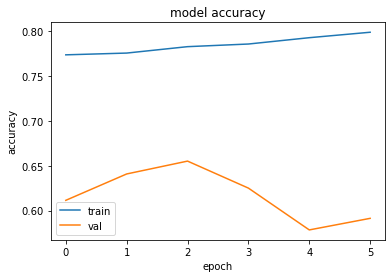

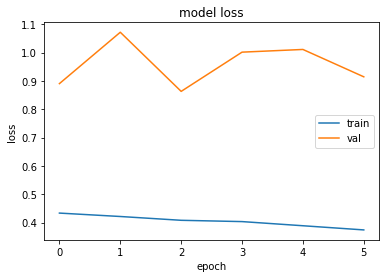

In [33]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

#summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

Here are the actual classes for each image
['mol_images/test/not_toxic/TOX5610.jpg', 'mol_images/test/not_toxic/TOX28720.jpg', 'mol_images/test/not_toxic/TOX29154.jpg', 'mol_images/test/toxic/TOX27463 copy 12.jpg', 'mol_images/test/not_toxic/TOX21045.jpg', 'mol_images/test/toxic/TOX26626 copy 7.jpg', 'mol_images/test/toxic/TOX27463 copy 21.jpg', 'mol_images/test/not_toxic/TOX21883.jpg', 'mol_images/test/not_toxic/TOX25658.jpg']
Below are the predictions


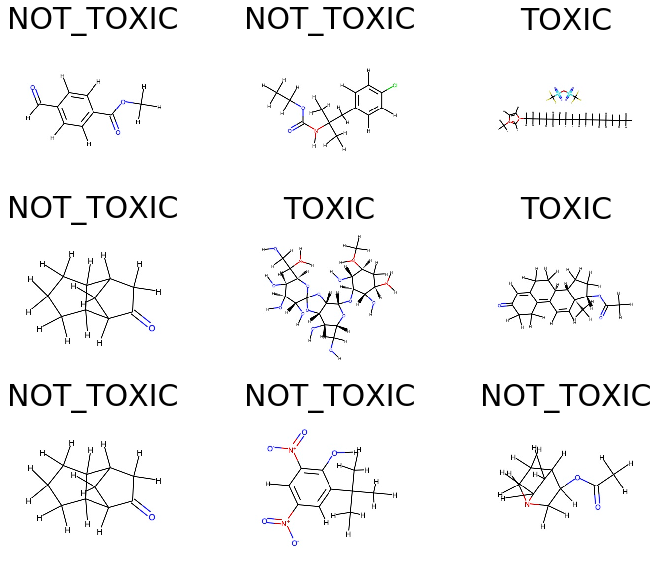

In [34]:
# extract 9 random images from the test set
imageset = glob(test_dir + "*/*")
random_images = [np.random.choice(imageset) for i in range(9)]

print('Here are the actual classes for each image')
print(random_images)
print('Below are the predictions')

# adjust the size of your images
plt.figure(figsize=(10,8))

# iterate and plot random images
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = cv2.imread(random_images[i])
    orig = img.copy()
    img = cv2.resize(img, (300,300))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img/255
    prediction = vgg16_model.predict(img)
    
    if (prediction < 0.5):
        plt.title("NOT_TOXIC", fontdict = {'fontsize' : 30})
    
    else:
        plt.title("TOXIC", fontdict = {'fontsize' : 30})
    plt.imshow(orig, cmap='gray')
    plt.axis('off')
    
# adjust subplot parameters to give specified padding
plt.tight_layout()